In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import shap

In [2]:
# Load dataset
file_path = "/content/Churn_Data.csv"
df = pd.read_csv(file_path)

In [3]:
# Handle missing values
imputer = SimpleImputer(strategy='median')  # For numerical columns
df[df.select_dtypes(include=['number']).columns] = imputer.fit_transform(df.select_dtypes(include=['number']))

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))

# Drop original categorical columns and add encoded features
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_features], axis=1)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [5]:
df.to_csv('/content/Processed_Customer_Churn.csv', index=False)

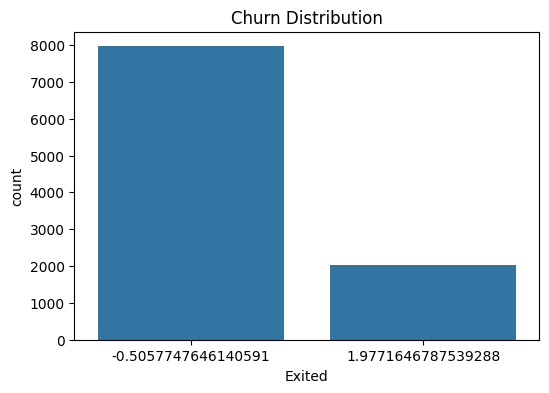

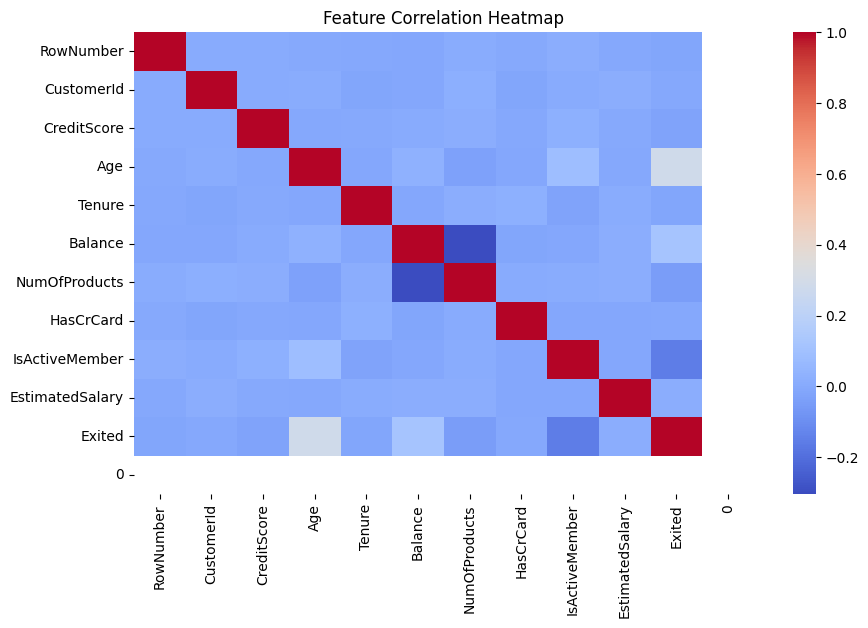

Churn class distribution:
 Exited
-0.505775    0.7963
 1.977165    0.2037
Name: proportion, dtype: float64


In [6]:
# Load processed data
df = pd.read_csv('/content/Processed_Customer_Churn.csv')
# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')
# Assuming 'churn' is the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Check class imbalance
churn_ratio = df['Exited'].value_counts(normalize=True)
print("Churn class distribution:\n", churn_ratio)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# Ensure target variable is properly encoded as integers
if "Exited" in df.columns:
    df["Exited"] = df["Exited"].astype(int)

# Train-test split
if "Exited" in df.columns:
    X = df.drop(columns=["Exited"])
    y = df["Exited"].astype(int)  # Explicitly convert to integer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Convert X_train and X_test to dense format (to avoid sparse matrix issues)
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)

    # Handle missing values before SMOTE
    smote_imputer = SimpleImputer(strategy="median")
    X_train = smote_imputer.fit_transform(X_train)
    X_test = smote_imputer.transform(X_test)

    # Address class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Ensure y_train_resampled is integer
    y_train_resampled = y_train_resampled.astype(int)

    # Train models
    log_model = LogisticRegression()
    dt_model = DecisionTreeClassifier()
    rf_model = RandomForestClassifier(n_estimators=100)

    log_model.fit(X_train_resampled, y_train_resampled)
    dt_model.fit(X_train_resampled, y_train_resampled)
    rf_model.fit(X_train_resampled, y_train_resampled)

    print("Baseline models trained successfully.")

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['0']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['0']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Baseline models trained successfully.


In [8]:
models = {"Logistic Regression": log_model, "Decision Tree": dt_model, "Random Forest": rf_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")


Logistic Regression Model Performance:
Accuracy: 0.7060
Precision: 0.3795
Recall: 0.7002
F1-score: 0.4922
AUC-ROC: 0.7039

Decision Tree Model Performance:
Accuracy: 0.7475
Precision: 0.4086
Recall: 0.5381
F1-score: 0.4645
AUC-ROC: 0.6695

Random Forest Model Performance:
Accuracy: 0.8260
Precision: 0.5778
Recall: 0.5381
F1-score: 0.5573
AUC-ROC: 0.7188


In [9]:
# Predictions
y_pred_log = log_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Model evaluation
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print("\n\nThe Best Model is RANDOM FOREST.")

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      1593
           1       0.38      0.70      0.49       407

    accuracy                           0.71      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.80      0.71      0.73      2000

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1593
           1       0.41      0.54      0.46       407

    accuracy                           0.75      2000
   macro avg       0.64      0.67      0.65      2000
weighted avg       0.78      0.75      0.76      2000

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1593
           1       0.58      0.54      0.56       407

    accuracy                           0.83      2000
   macro

/tmp/ipython-input-10-4213797342.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


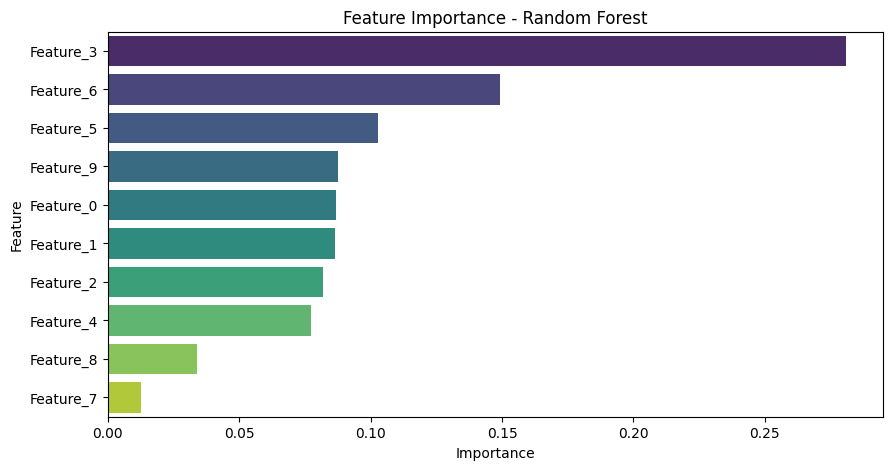

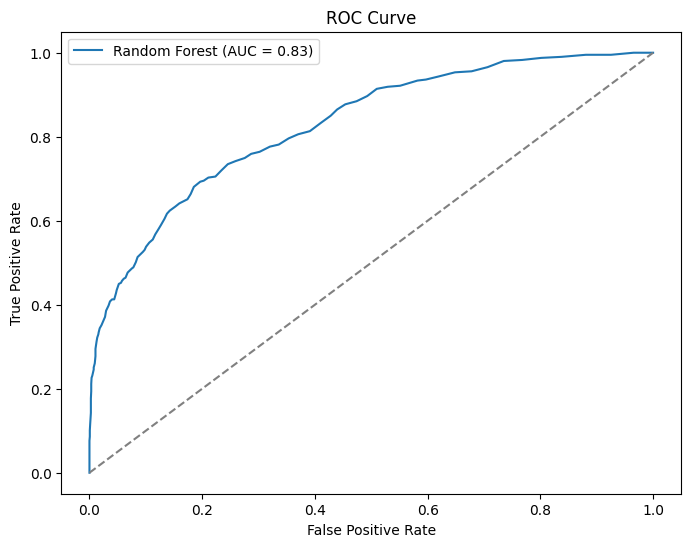

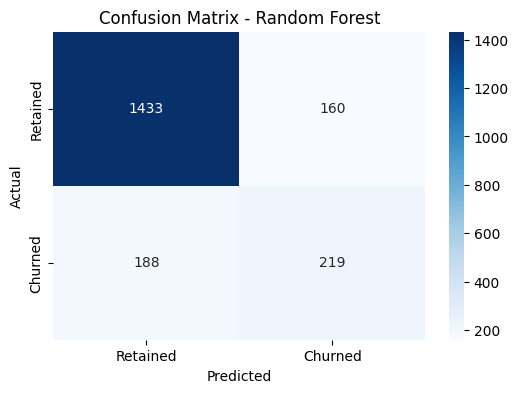

In [10]:
# Ensure feature names match the transformed dataset
if "Exited" in df.columns:
    original_feature_names = df.drop(columns=["Exited"]).columns.tolist()  # Get original feature names

    # After transformations, check the final shape of X_train_resampled
    if len(original_feature_names) == len(rf_model.feature_importances_):
        feature_names = original_feature_names  # Use original feature names if sizes match
    else:
        feature_names = [f"Feature_{i}" for i in range(len(rf_model.feature_importances_))]  # Fallback generic names

    # Feature Importance for Random Forest
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_model.feature_importances_})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title("Feature Importance - Random Forest")
    plt.show()

# ROC Curve
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
auc_score = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()